In [66]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import time
import datetime

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

import nltk
from nltk.stem import SnowballStemmer
import pymorphy2

1. Скачивание датасета, проверка на одинаковые строчки и NaN значения
2. Preprocessing (перевод в нижний регистр, удаление знаков препинания)
3. Удаление стоп-слов
4. stemming
5. lemmatization
6. tfidf
7. Выбор модели по cross-validation на пяти фолдах
8. обучение и предсказание
 

In [67]:
from nltk.corpus import stopwords
stopwords.words('russian')

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

# 1. Скачивание датасета

In [68]:
data = pd.read_csv('train_k.tsv', sep='\t')
print(data['title'].describe())

count                                                  5758
unique                                                 5757
top       В США зафиксировано рекордное количество банкр...
freq                                                      2
Name: title, dtype: object


'В США зафиксировано рекордное количество банкротств' удаляем строчку, тк встречается два раза

In [69]:
data[data['title']== 'В США зафиксировано рекордное количество банкротств']
data = data.drop([402],axis=0).reset_index(drop=True)

In [70]:
print(data.isnull().sum())

title      0
is_fake    0
dtype: int64


Нет NaN значений

In [71]:
xx = data.drop('is_fake',axis=1)
xx

,title
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...
1,Агент Кокорина назвал езду по встречке житейск...
2,Госдума рассмотрит возможность введения секрет...
3,ФАС заблокировала поставку скоростных трамваев...
4,Против Навального завели дело о недоносительст...
...,...
5752,Эдди Чемберс получил сотрясение мозга в бою с ...
5753,Правительство застроит Россию нефтепродуктопро...
5754,«Мне стыдно перед дедом»: новый канцлер ФРГ об...
5755,Туркмения в декабре начнет поставки газа в Китай


In [72]:
y = yy.to_numpy()
y

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

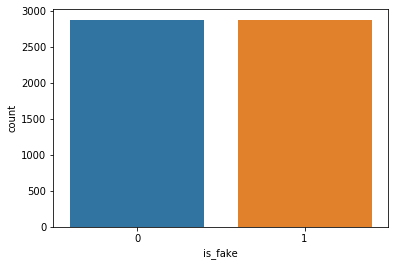

In [73]:
sns.countplot(data['is_fake'])

# 2. transform to lower and del punctuations


In [74]:
docs = []
for sen in range(0, len(xx)):
    
    # Converting to Lowercase
    doc = xx['title'][sen].lower()
    doc = re.sub(r'[^\w\s]', '', doc)
    # Lemmatization
    doc = doc.split()
    # stop words
    # doc = [snowball.stem(word) for word in doc]
    doc = ' '.join(doc)
    docs.append(doc)
docs

['москвичу владимиру клутину пришёл счёт за вмешательство в американские выборы',
 'агент кокорина назвал езду по встречке житейской историей',
 'госдума рассмотрит возможность введения секретных статей уголовного кодекса',
 'фас заблокировала поставку скоростных трамваев для москвы',
 'против навального завели дело о недоносительстве на волкова',
 'российским студентам запретят учиться за рубежом',
 'путин пишет книгу об истории украины',
 'россияне обхитрили рост цен',
 'звезда ворониных раскрыл подробности о своем состоянии',
 'microsoft объявила дату выхода очков дополненной реальности hololens',
 'марат хуснуллин призвал прописать в законе понятие многонационального дома',
 'для проведения профилактических работ с 15 по 19 сентября в россии отключат интернет',
 'в россии введут обязательный техосмотр садового инвентаря',
 'топилин провозгласил окончание зарплатного кризиса в россии',
 'режиссера алексея германа наградили орденом',
 'олаф шольц дед рассказывал какие вкусные на укра

# 3. Delete stop words

In [75]:
documents = []

for sen in range(0, len(docs)):
    document = nltk.word_tokenize(docs[sen])
    document = [word for word in document if not word in stopwords.words('russian')]
    document = ' '.join(document)
    documents.append(document)
documents

['москвичу владимиру клутину пришёл счёт вмешательство американские выборы',
 'агент кокорина назвал езду встречке житейской историей',
 'госдума рассмотрит возможность введения секретных статей уголовного кодекса',
 'фас заблокировала поставку скоростных трамваев москвы',
 'против навального завели дело недоносительстве волкова',
 'российским студентам запретят учиться рубежом',
 'путин пишет книгу истории украины',
 'россияне обхитрили рост цен',
 'звезда ворониных раскрыл подробности своем состоянии',
 'microsoft объявила дату выхода очков дополненной реальности hololens',
 'марат хуснуллин призвал прописать законе понятие многонационального дома',
 'проведения профилактических работ 15 19 сентября россии отключат интернет',
 'россии введут обязательный техосмотр садового инвентаря',
 'топилин провозгласил окончание зарплатного кризиса россии',
 'режиссера алексея германа наградили орденом',
 'олаф шольц дед рассказывал какие вкусные украине куры молоко яйца',
 'беглов петербург осн

# 4. Stemming

In [76]:
docs1 = []
from nltk.stem import SnowballStemmer
snowball = SnowballStemmer(language="russian")

for sen in range(0, len(documents)):#ocuments)):
    doc = documents[sen]
    doc = doc.split()
    #stemming
    doc = [snowball.stem(word) for word in doc]
    doc = ' '.join(doc)
    docs1.append(doc)
docs1

['москвич владимир клутин пришел счет вмешательств американск выбор',
 'агент кокорин назва езд встречк житейск истор',
 'госдум рассмотр возможн введен секретн стат уголовн кодекс',
 'фас заблокирова поставк скоростн трамва москв',
 'прот навальн завел дел недоносительств волков',
 'российск студент запрет уч рубеж',
 'путин пишет книг истор украин',
 'россиян обхитр рост цен',
 'звезд воронин раскр подробн сво состоян',
 'microsoft объяв дат выход очк дополнен реальност hololens',
 'марат хуснуллин призва прописа закон понят многонациональн дом',
 'проведен профилактическ работ 15 19 сентябр росс отключат интернет',
 'росс введут обязательн техосмотр садов инвентар',
 'топилин провозглас окончан зарплатн кризис росс',
 'режиссер алексе герма наград орден',
 'олаф шольц дед рассказыва как вкусн украин кур молок яйц',
 'бегл петербург основа наш эр полтор тысяч лет старш москв',
 'случа дефицит препарат эпиваккорон храм рпц проведут вакцинац свят вод',
 'энтон андерсон стал молод папаш

# 5. Lemmatization

In [77]:
d = []
morph = pymorphy2.MorphAnalyzer()
for sen in range(0, len(docs1)):
    doc = docs1[sen]
    doc = doc.split()
    doc = [morph.parse(word)[0].normal_form for word in doc]
    doc = ' '.join(doc)
    d.append(doc)
d

['москвич владимир клутиный прийти счёт вмешательство американск выбор',
 'агент кокорин назвый езд встречк житейск истора',
 'госдума рассмотр возможн ввести секретн стат уголовна кодекс',
 'фас заблокиров поставк скоростн трамв москва',
 'прота навальна завести дело недоносительство волков',
 'российск студент запрет уч рубеж',
 'путин писать книга истора украина',
 'россиянин обхитр рост цена',
 'звезда воронин раскр подробн сво состоять',
 'microsoft объять дата выход очк дополнить реальност hololens',
 'марат хуснуллин призвый прописа закон понять многонациональна дом',
 'провести профилактическ работа 15 19 сентябра росс отключить интернет',
 'росс ввести обязательна техосмотр сад инвентара',
 'топилина провозглас окончан зарплатн кризис росс',
 'режиссёр алекс герма награда орден',
 'олафа шольц дед рассказыв как вкусна украина кура молока яйц',
 'беглый петербург основа наш эра полтор тысяча год старша москва',
 'случ дефицит препарат эпиваккорона храм рпц провести вакцинац свя

# 6. tfidf (count vectorizer + tfidtransformer)



In [78]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(d)
X_train_counts.shape

(5757, 10819)

In [79]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf

<5757x10819 sparse matrix of type '<class 'numpy.float64'>'
	with 41110 stored elements in Compressed Sparse Row format>

# 7. Выбор модели

берем стеккинг алгоритмов, что дает скор 0.869.

svm - ~0.84

MultinomialNB ~ 0.855

lr - ~0.829

rf - <0.781

Параметры у svc нашел через gridsearch





In [80]:
from sklearn.model_selection import GridSearchCV
cval = KFold(n_splits=5, shuffle= True, random_state = 1)
st = datetime.datetime.now()
su = 0 
for train, test in cval.split(X_train_tfidf,y):
    start_time = datetime.datetime.now()
    x_train, x_test, y_train, y_test = X_train_tfidf[train], X_train_tfidf[test], y[train], y[test]
    #model = RandomForestClassifier(n_estimators=150,random_state=0)
    #model = LogisticRegression(penalty='l2',C=100)
    #model = SVC(C=100,kernel='poly')
    #model = MultinomialNB()
    level0 = list()
    level0.append(('NB', MultinomialNB()))
    level0.append(('svc', SVC(C=100,kernel='poly')))
    level0.append(('rf', RandomForestClassifier(n_estimators=150,random_state=0)))
    

    level1 = LogisticRegression(penalty='l2',C=100)
    
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=2)
    #parameters = {'kernel':('linear', 'rbf', poly), 'C':[1, 10, 100]}
    #gs_clf_svm = GridSearchCV(svc, parameters, n_jobs=-1)
    #gs_clf_svm = gs_clf_svm.fit(x_train, y_train)
    #print(gs_clf_svm.best_score_)
    #print(gs_clf_svm.best_params_)
    print('train')
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    print(pred)
    met = f1_score(y_test,pred)
    print('score: ', met)
    su+=met
    print('-----')
print(su/5)
    

train
[1 1 1 ... 0 1 0]
score:  0.8747731397459166
-----
train
[1 1 1 ... 1 1 1]
score:  0.8723221936589547
-----
train
[0 0 1 ... 0 1 0]
score:  0.8610400682011935
-----
train
[1 0 1 ... 0 1 1]
score:  0.862882096069869
-----
train
[1 1 1 ... 1 0 0]
score:  0.8751047778709137
-----
0.8692244551093694


# 8. обучение и предсказание

Проделываем все те же самые преобразования, что и с train выборкой

In [81]:
t = pd.read_csv('test_k.tsv', sep = '\t')
x_test = t['title']
x_test

0      Роскомнадзор представил реестр сочетаний цвето...
1      Ночью под Минском на президентской горе Белара...
2      Бывший спичрайтер Юрия Лозы рассказал о трудно...
3      Сельская церковь, собравшая рекордно низкое ко...
4      Акции Google рухнули после объявления о переза...
                             ...                        
995    Прокуратура заподозрила Явлинского в авторитар...
996    В День Победы стратегические ракетоносцы Ту-16...
997    СК возбудил дело против авиакомпании «Победа» ...
998    Криптомонетный двор Туркменистана выпустил юби...
999    Deutsche Bahn заплатит рекордный штраф за чтен...
Name: title, Length: 1000, dtype: object

In [44]:
docs_test = []
for sen in range(0, len(t)):
    # Converting to Lowercase
    doc = t['title'][sen].lower()
    doc = re.sub(r'[^\w\s]', '', doc)
    doc = doc.split()
    doc = ' '.join(doc)
    docs_test.append(doc)
docs_test

['роскомнадзор представил реестр сочетаний цветов нежелательных в россии',
 'ночью под минском на президентской горе беларашмор пик демократии внезапно появилось лицо николая лукашенко',
 'бывший спичрайтер юрия лозы рассказал о трудностях работы с сергеем шойгу',
 'сельская церковь собравшая рекордно низкое количество пожертвований сгорела от тройного попадания молнии',
 'акции google рухнули после объявления о перезапуске rutube',
 'курс доллара вырос до исторического максимума',
 'опек назвала оптимальный уровень цен на нефть',
 'российская авиакомпания откроет рейсы в тбилиси с урала',
 'швейцарская горнолыжница расстреляна в доме родителей',
 'учреждена театральная премия имени гарольда пинтера',
 'песков опроверг информацию о слиянии минфина и минэкономразвития',
 'в рамках акции елка желаний министр науки и высшего образования исполнил мечту алисы тепляковой и подарил ей красный диплом мгу',
 'главного злодея в сериале этерна сыграет роман мадянов',
 'таркан признался в употребл

In [45]:
documents_t = []

for sen in range(0, len(docs_test)):
    document = nltk.word_tokenize(docs_test[sen])
    document = [word for word in document if not word in stopwords.words('russian')]
    document = ' '.join(document)
    documents_t.append(document)
documents_t

['роскомнадзор представил реестр сочетаний цветов нежелательных россии',
 'ночью минском президентской горе беларашмор пик демократии внезапно появилось лицо николая лукашенко',
 'бывший спичрайтер юрия лозы рассказал трудностях работы сергеем шойгу',
 'сельская церковь собравшая рекордно низкое количество пожертвований сгорела тройного попадания молнии',
 'акции google рухнули объявления перезапуске rutube',
 'курс доллара вырос исторического максимума',
 'опек назвала оптимальный уровень цен нефть',
 'российская авиакомпания откроет рейсы тбилиси урала',
 'швейцарская горнолыжница расстреляна доме родителей',
 'учреждена театральная премия имени гарольда пинтера',
 'песков опроверг информацию слиянии минфина минэкономразвития',
 'рамках акции елка желаний министр науки высшего образования исполнил мечту алисы тепляковой подарил красный диплом мгу',
 'главного злодея сериале этерна сыграет роман мадянов',
 'таркан признался употреблении кокаина',
 'екатеринбурге завершился процесс бес

In [46]:
docs1_t = []
from nltk.stem import SnowballStemmer
snowball = SnowballStemmer(language="russian")

for sen in range(0, len(documents_t)):#ocuments)):
    doc = documents_t[sen]
    doc = doc.split()
    #stemming
    doc = [snowball.stem(word) for word in doc]
    doc = ' '.join(doc)
    docs1_t.append(doc)
docs1_t

['роскомнадзор представ реестр сочетан цвет нежелательн росс',
 'ноч минск президентск гор беларашмор пик демократ внезапн появ лиц никол лукашенк',
 'бывш спичрайтер юр лоз рассказа трудност работ серге шойг',
 'сельск церков собра рекордн низк количеств пожертвован сгорел тройн попадан молн',
 'акц google рухнул объявлен перезапуск rutube',
 'курс доллар вырос историческ максимум',
 'опек назва оптимальн уровен цен нефт',
 'российск авиакомпан откроет рейс тбилис ура',
 'швейцарск горнолыжниц расстреля дом родител',
 'учрежд театральн прем имен гарольд пинтер',
 'песк опроверг информац слиян минфин минэкономразвит',
 'рамк акц елк желан министр наук высш образован исполн мечт алис тепляков подар красн дипл мгу',
 'главн злоде сериал этерн сыгра рома мадян',
 'тарка призна употреблен кокаин',
 'екатеринбург заверш процесс бес',
 'дэниел крейг посел дом призрак',
 'нов тренер спартак покинет клуб конц год',
 'биткоин затм ким кардашья',
 'фон сообщен побед един росс выбор госдум немецк

In [47]:
d_t = []
morph = pymorphy2.MorphAnalyzer()
for sen in range(0, len(docs1_t)):
    doc = docs1_t[sen]
    doc = doc.split()
    doc = [morph.parse(word)[0].normal_form for word in doc]
    doc = ' '.join(doc)
    d_t.append(doc)
d_t

['роскомнадзор предстать реестр сочетать цвет нежелательна росс',
 'ноч минск президентск гора беларашмор пик демократ внезапн поять лицо никола лукашенк',
 'бывш спичрайтер юр лоза рассказ трудност работа серг шойга',
 'сельск церковы собра рекордна низк количество пожертвовать сгореть тройна попадан молна',
 'акц google рухнуть объявить перезапуск rutube',
 'курс доллар вырасти историческ максимум',
 'опек назвый оптимальна уровена цена нефт',
 'российск авиакомпан открыть рейс тбилиса ура',
 'швейцарск горнолыжница расстрелить дом родитело',
 'учрежда театральна переть имя гарольд пинтер',
 'песк опровергнуть информаца слияна минфин минэкономразвитый',
 'рамк акц елк желана министр наука высш образовать исполна мечта алиса тепляк подар красна диплый мгу',
 'главна злода сериал этёрн сыгра рома мадянин',
 'тарка призный употребить кокаин',
 'екатеринбург заверша процесс бес',
 'дэниел крейг посесть дом призрак',
 'новый тренер спартак покинуть клуб конц год',
 'биткоина затм ким кард

In [48]:
X_test_tf = count_vect.transform(d_t)
X_test__tfidf = tfidf_transformer.transform(X_test_tf)
X_test__tfidf

<1000x10819 sparse matrix of type '<class 'numpy.float64'>'
	with 6020 stored elements in Compressed Sparse Row format>

In [49]:
level0 = list()
level0.append(('NB', MultinomialNB()))
level0.append(('svc', SVC(C=100,kernel='poly')))
level0.append(('rf', RandomForestClassifier(n_estimators=150,random_state=0)))
    

level1 = LogisticRegression(penalty='l2',C=100)
    
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=2)

model.fit(X_train_tfidf, y)

StackingClassifier(cv=2,
                   estimators=[('NB',
                                MultinomialNB(alpha=1.0, class_prior=None,
                                              fit_prior=True)),
                               ('svc',
                                SVC(C=100, break_ties=False, cache_size=200,
                                    class_weight=None, coef0=0.0,
                                    decision_function_shape='ovr', degree=3,
                                    gamma='scale', kernel='poly', max_iter=-1,
                                    probability=False, random_state=None,
                                    shrinking=True, tol=0.001, verbose=False)),
                               ('rf',
                                RandomFores...
                                                       random_state=0,
                                                       verbose=0,
                                                       warm_start=False))],
        

In [50]:
predicted = model.predict(X_test__tfidf)
predicted

array([1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,

In [51]:
predicted.shape

(1000,)

In [52]:
t['is_fake'] = predicted
t

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,1
1,Ночью под Минском на президентской горе Белара...,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0
...,...,...
995,Прокуратура заподозрила Явлинского в авторитар...,1
996,В День Победы стратегические ракетоносцы Ту-16...,1
997,СК возбудил дело против авиакомпании «Победа» ...,1
998,Криптомонетный двор Туркменистана выпустил юби...,1


In [53]:
idx = np.arange(predicted.shape[0])
list_of_tuples = list(zip(t['title'], predicted))

df = pd.DataFrame(list_of_tuples,
                  columns = ['title', 'is_fake'])
    

df.to_csv('predictions.tsv', index = False)
